# BERT Classifier

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Colab_Notebooks/News_Analytics_Project/transformer')

In [3]:
import os

import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoConfig
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np
import dataset
import model
import trainer
import text_helper_bert

torch.manual_seed(42)

In [4]:
data_path = '/content/gdrive/MyDrive/Colab_Notebooks/News_Analytics_Project/data'

In [5]:
train_data = pd.read_csv(os.path.join(data_path,'train_data.csv'))
test_data = pd.read_csv(os.path.join(data_path,'test_data.csv'))
df = pd.read_csv(os.path.join(data_path,'news_final_balanced.csv'))

## Split data into test and validation sets

In [6]:
le = LabelEncoder()
train_data.topic = le.fit_transform(train_data.topic)
test_data.topic = le.fit_transform(test_data.topic)

In [7]:
val_data, test_data = train_test_split(test_data, train_size=0.5, random_state=42)

In [8]:
data = {
    'train': [f'{train_data.shape[0]} ({len(train_data) / len(df) * 100:.0f}%)'],
    'valid': [f'{val_data.shape[0]} ({len(val_data) / len(df) * 100:.0f}%)'],
    'test': [f'{test_data.shape[0]} ({len(test_data) / len(df) * 100:.0f}%)']
}

df_percentages = pd.DataFrame(data)
df_percentages

,train,valid,test
0,33768 (80%),4221 (10%),4221 (10%)


## Preprocess text

BERT relies on contextual embeddings, meaning it considers the context of each word in a sentence rather than treating words independently.
As a result, we do not need lemmatization here. We just remove links,'\xa0', source, data and authors of the news.

In [9]:
%%time
train_data = text_helper_bert.preprocess_text(train_data, only_titles=False)
val_data = text_helper_bert.preprocess_text(test_data, only_titles=False)

CPU times: user 6.55 s, sys: 156 ms, total: 6.71 s
Wall time: 6.69 s


In [10]:
train_data.loc[2][['content', 'title', 'text_clean']].tolist()

['МОСКВА, 11 ноя - РИА Новости. Выявить подделку на маркетплейсе можно, просканировав QR-код маркировки после получения товара, рассказала агентству “Прайм” доцент кафедры товароведения и товарной экспертизы РЭУ им. Г.В. Плеханова Елена Райкова. Еще до покупки следует изучить информацию на карточке товара, отзывы, фото и видео. А также оценить профиль продавца на маркетплейсе. В пункте выдачи нужно проверить покупку на наличие маркировки “Честный знак” и просканировать код через соответствующее приложение. Код содержит всю информацию о качестве, составе, стране происхождения и безопасности товара. «“Таким образом можно проверять обувь и одежду, фотоаппараты, велосипеды, пищевые продукты, лекарства, БАДы”, - объяснила Райкова. Кроме этого, товар нужно оценить визуально - нет ли повреждений, цела ли упаковка. Если это бытовая техника, проверить ее работоспособность. С претензиями следует обращаться на маркетплейс в течение 14 дней после покупки.',
 'Покупателям объяснили, как выявить под

## Load tokenizer

In [11]:
tokenizer = AutoTokenizer.from_pretrained(
    "cointegrated/rubert-tiny2", truncation=True, do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Create datasets and dataloaders

In [12]:
MAX_LEN = 512
BATCH_SIZE = 64

train_dataset = dataset.CustomDataset(train_data, tokenizer, MAX_LEN)
val_dataset = dataset.CustomDataset(val_data, tokenizer, MAX_LEN)

train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 0
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 0
               }

train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **test_params)

## Load pretrained model from Huggingface

In [13]:
config = AutoConfig.from_pretrained("cointegrated/rubert-tiny2")
config.update({'output_hidden_states': True})

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

## Custom configuration

In [14]:
custom_config = {"num_classes":len(np.unique(train_data.topic)),
               "dropout_rate": 0.1}

model = model.ModelForClassification(
    "cointegrated/rubert-tiny2",
    config=config,
    custom_config=custom_config
)

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

## Fit the model

In [15]:
%%time
trainer_config = {
    "lr": 3e-4,
    "n_epochs": 10,
    "weight_decay": 1e-6,
    "batch_size": BATCH_SIZE,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}
t = trainer.Trainer(trainer_config, label_encoder=le)

t.fit(
    model,
    train_dataloader,
    val_dataloader
)

Epoch 1/10


  0%|          | 0/528 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AVG LOSS =  0.5590207752574122


  0%|          | 0/66 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.8642501831054688
Loss=0.412; Acc:0.864; F1 Macro:0.862
All ACCURACY =  0.8642501831054688
Epoch 2/10


  0%|          | 0/528 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AVG LOSS =  0.35329982906467083


  0%|          | 0/66 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.8824923038482666
Loss=0.366; Acc:0.882; F1 Macro:0.882
All ACCURACY =  0.8733712434768677
Epoch 3/10


  0%|          | 0/528 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AVG LOSS =  0.276795800097964


  0%|          | 0/66 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.8850982785224915
Loss=0.362; Acc:0.885; F1 Macro:0.883
All ACCURACY =  0.8772802551587423
Epoch 4/10


  0%|          | 0/528 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AVG LOSS =  0.21338293251271048


  0%|          | 0/66 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.8855721354484558
Loss=0.383; Acc:0.886; F1 Macro:0.883
All ACCURACY =  0.8793532252311707
Epoch 5/10


  0%|          | 0/528 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AVG LOSS =  0.15795218010404796


  0%|          | 0/66 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.8808339238166809
Loss=0.411; Acc:0.881; F1 Macro:0.88
All ACCURACY =  0.8796493649482727
Epoch 6/10


  0%|          | 0/528 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AVG LOSS =  0.11742161844052713


  0%|          | 0/66 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.8808339238166809
Loss=0.45; Acc:0.881; F1 Macro:0.879
All ACCURACY =  0.8798467914263407
Epoch 7/10


  0%|          | 0/528 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AVG LOSS =  0.08589262182817259


  0%|          | 0/66 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.8791755437850952
Loss=0.498; Acc:0.879; F1 Macro:0.879
All ACCURACY =  0.8797508989061628
Epoch 8/10


  0%|          | 0/528 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AVG LOSS =  0.060944864738937184


  0%|          | 0/66 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.8867566585540771
Loss=0.535; Acc:0.887; F1 Macro:0.886
All ACCURACY =  0.8806266188621521
Epoch 9/10


  0%|          | 0/528 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AVG LOSS =  0.04315094821812994


  0%|          | 0/66 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.8813077211380005
Loss=0.581; Acc:0.881; F1 Macro:0.88
All ACCURACY =  0.8807022968928019
Epoch 10/10


  0%|          | 0/528 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


AVG LOSS =  0.036065765800506626


  0%|          | 0/66 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.876095712184906
Loss=0.624; Acc:0.876; F1 Macro:0.876
All ACCURACY =  0.8802416384220123
CPU times: user 53min 7s, sys: 9.55 s, total: 53min 16s
Wall time: 52min 52s


ModelForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

In [16]:
t.save('/content/gdrive/MyDrive/Colab_Notebooks/News_Analytics_Project/transformer/baseline_bert_model.ckpt')

## Get predictions for test data

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


F1 Score Macro Average: 0.876
                precision    recall  f1-score   support

       culture       0.94      0.94      0.94       479
defense_safety       0.90      0.80      0.85       483
       economy       0.89      0.93      0.91       473
     incidents       0.88      0.89      0.89       479
      politics       0.78      0.85      0.82       500
      religion       0.96      0.96      0.96       455
       science       0.94      0.96      0.95       439
       society       0.73      0.76      0.75       431
         world       0.87      0.79      0.83       482

      accuracy                           0.88      4221
     macro avg       0.88      0.88      0.88      4221
  weighted avg       0.88      0.88      0.88      4221



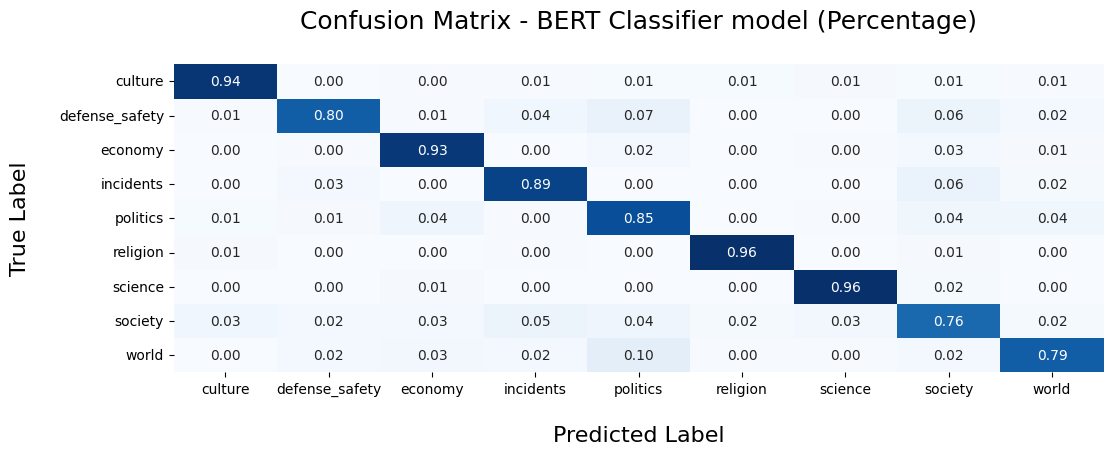

,model,vectorizer,f1,predicting time
0,BERT Classifier model,rubert-tiny2,0.876,17.861081


In [17]:
test_data = text_helper_bert.preprocess_text(test_data, only_titles=False)
test_dataset = dataset.CustomDataset(test_data, tokenizer, MAX_LEN)
test_dataloader = DataLoader(test_dataset, **test_params)
predictions = t.predict(test_dataloader)
result_df, y_test, y_pred = t.test_evaluate(test_dataloader, model_name='BERT Classifier model', vectorizer_name='rubert-tiny2')
result_df

In [18]:
summary_ml = pd.read_csv(os.path.join(data_path,'summary_ml.csv'))
summary = pd.concat([summary_ml, result_df], ignore_index=True)
summary.to_csv(os.path.join(data_path,'summary_final.csv'), index=False)
summary

,model,vectorizer,f1,predicting time
0,LogisticRegression,Tfidf,0.881,2.648436
1,LogisticRegression,Word2Vec with Mean Pooling,0.859,3.920810
2,CatBoostClassifier,NaiveBayes built-in CatBoostClassifier,0.875,0.837941
3,BERT Classifier model,rubert-tiny2,0.876,17.861081
